# Experiments Theory of Mind in teacher-learner gridworld setup 
## Bayesian models

In [1]:
from __future__ import annotations
import warnings

from minigrid.core.actions import Actions
from minigrid.core.constants import IDX_TO_COLOR, DIR_TO_VEC

import numpy as np
import pickle
import csv
import matplotlib.pyplot as plt
from tqdm import trange, tqdm
import progressbar
import pandas as pd

from matplotlib.backends.backend_agg import FigureCanvasAgg
import matplotlib.gridspec as gridspec
from IPython.display import clear_output
from PIL import Image

from environment import MultiGoalsEnv, MultiRoomsGoalsEnv
from learner import BayesianLearner
from bayesian_teacher import AlignedBayesianTeacher, BayesianTeacher
from utils import *
from utils_viz import *

warnings.filterwarnings("ignore", category=RuntimeWarning)

pygame 2.4.0 (SDL 2.26.4, Python 3.11.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Parameters

GRID_SIZE = 15
GRID_SIZE_DEMO = 45
num_colors = 4
rf_values_basic = [3, 5, 7]
RF_VALUES = rf_values_basic + [GRID_SIZE]
RF_VALUES_DEMO = rf_values_basic + [GRID_SIZE_DEMO]

## Environment

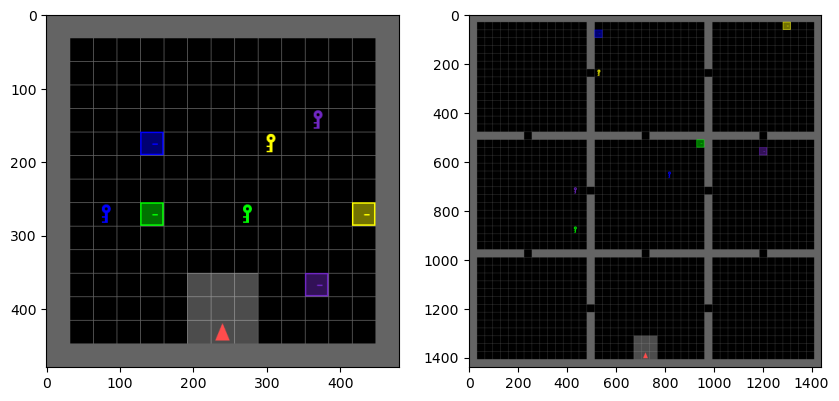

In [3]:
fig = plt.figure(figsize=(10, 5))

env = MultiGoalsEnv(
    render_mode="rgb_array",
    agent_goal=0,
    agent_view_size=3,
    agent_start_pos=(GRID_SIZE // 2, GRID_SIZE - 2),
    agent_start_dir=3,
    size=GRID_SIZE,
)
_ = env.reset()

fig.add_subplot(1, 2, 1)
plt.imshow(env.render())

env_demo = MultiRoomsGoalsEnv(
    render_mode="rgb_array",
    agent_goal=0,
    agent_view_size=3,
    agent_start_pos=(GRID_SIZE_DEMO // 2, GRID_SIZE_DEMO - 2),
    agent_start_dir=3,
    size=GRID_SIZE_DEMO,
)
_ = env_demo.reset()

fig.add_subplot(1, 2, 2)
plt.imshow(env_demo.render());

## Learner (Bayesian - RL)

In [ ]:
receptive_field = 5
goal_color = 0

learner = BayesianLearner(
    goal_color=goal_color,
    receptive_field=receptive_field,
    grid_size=GRID_SIZE,
    env_type="MultiGoalsEnv",
)  # , save_render=True)
images = display_learner_play(GRID_SIZE, learner)

In [ ]:
receptive_field = GRID_SIZE_DEMO
goal_color = 0

learner = BayesianLearner(
    goal_color=goal_color,
    receptive_field=receptive_field,
    grid_size=GRID_SIZE_DEMO,
    env_type="MultiRoomsGoalsEnv",
)  # , save_render=True)
images = display_learner_play(GRID_SIZE_DEMO, learner)

In [ ]:
receptive_field = 7
goal_color = 1

learner = BayesianLearner(
    goal_color=goal_color,
    receptive_field=receptive_field,
    grid_size=GRID_SIZE_DEMO,
    env_type="MultiRoomsGoalsEnv",
)
learner.play()

print(
    f" Learner with rf={receptive_field} for goal_color={goal_color} ({IDX_TO_COLOR[goal_color+1]}) \n \
      Step count: {learner.env.step_count} (max_steps={learner.env.max_steps}) \n \
      Reward: {learner.reward:.4f}"
)

In [ ]:
learner.reset()
learner.play()

print(
    f" Learner with rf={receptive_field} for goal_color={goal_color} ({IDX_TO_COLOR[goal_color+1]}) \n \
      Step count: {learner.env.step_count} (max_steps={learner.env.max_steps}) \n \
      Reward: {learner.reward:.4f}"
)

### Statistics on different learners

In [ ]:
# Paremeters

GRID_SIZE = 15
N = 200

env_type = "MultiGoalsEnv"

if env_type == "MultiGoalsEnv":
    grid_size = GRID_SIZE
    rf_values = rf_values_basic + [GRID_SIZE]

elif env_type == "MultiRoomsGoalsEnv":
    grid_size = GRID_SIZE_DEMO
    rf_values = rf_values_basic + [GRID_SIZE_DEMO]

print(
    f"Environment {env_type} \n \
      grid_size {grid_size} \n \
      rf_values {rf_values}"
)

In [ ]:
mean_reward_all = np.zeros((num_colors, len(rf_values)))
std_reward_all = np.zeros((num_colors, len(rf_values)))

mean_count_all = np.zeros((num_colors, len(rf_values)))
std_count_all = np.zeros((num_colors, len(rf_values)))

for goal_color in range(num_colors):
    for ii, receptive_field in enumerate(rf_values):
        rewards_all = []
        counts_all = []
        for _ in trange(N):
            learner = BayesianLearner(
                goal_color=goal_color,
                receptive_field=receptive_field,
                grid_size=grid_size,
                env_type=env_type,
            )
            learner.play()

            # if learner.reward == 0:
            #     # assert(False)
            #     print(f'Exceed max_steps={learner.env.max_steps}')
            # Stats
            rewards_all.append(learner.reward)
            counts_all.append(learner.env.step_count)

        mean_reward_all[goal_color, ii] = np.mean(rewards_all)
        std_reward_all[goal_color, ii] = 1.96 * np.std(rewards_all) / np.sqrt(N)

        mean_count_all[goal_color, ii] = np.mean(counts_all)
        std_count_all[goal_color, ii] = 1.96 * np.std(counts_all) / np.sqrt(N)

In [ ]:
# # Save frames
# gif_file = f"./outputs_rendering/bug/output.gif"
# pil_images = [Image.fromarray(image.astype('uint8'), 'RGB') for image in learner.render_frames]
# pil_images[0].save(gif_file, save_all=True, append_images=pil_images[1:], duration=100, loop=0)

# # Save associeted beliefs entropy
# gif_file = f"./outputs_rendering/bug/output_belief.gif"
# pil_images = [Image.fromarray(image / (Shannon_entropy( 1 / 4 * np.ones(4)) + 0.5) * 255) for image in learner.render_beliefs]
# pil_images[0].save(gif_file, save_all=True, append_images=pil_images[1:], duration=100, loop=0)

In [ ]:
import pandas as pd

mean_std_reward = np.zeros((num_colors, len(rf_values))).astype(str)

for g in range(num_colors):
    for ii, rf in enumerate(rf_values):
        mean_std_reward[g, ii] = (
            str(np.round(mean_reward_all[g, ii], 4))
            + " +/- "
            + str(np.round(std_reward_all[g, ii], 4))
        )

df_reward = pd.DataFrame(
    mean_std_reward,
    columns=np.array(rf_values).astype("str"),
    index=["Green", "Blue", "Purple", "Yellow"],
)

mean_std_count = np.zeros((num_colors, len(rf_values))).astype(str)

for g in range(num_colors):
    for ii, rf in enumerate(rf_values):
        mean_std_count[g, ii] = (
            str(np.round(mean_count_all[g, ii], 4))
            + " +/- "
            + str(np.round(std_count_all[g, ii], 4))
        )

df_count = pd.DataFrame(
    mean_std_count,
    columns=np.array(rf_values).astype("str"),
    index=["Green", "Blue", "Purple", "Yellow"],
)

print("Reward per type of learner")
display(df_reward)
print("# of step to fininsh the task per type of learner")
display(df_count)

In [ ]:
mean_std_reward = np.zeros(len(rf_values)).astype(str)

for ii, rf in enumerate(rf_values):
    mean_std_reward[ii] = (
        str(np.round(np.mean(mean_reward_all[:, ii]), 4))
        + " +/- "
        + str(np.round(np.mean(std_reward_all[:, ii]), 4))
    )

df_reward = pd.DataFrame(
    mean_std_reward.reshape((1, 4)),
    columns=np.array(rf_values).astype("str"),
    index=["learner"],
)

mean_std_count = np.zeros(len(rf_values)).astype(str)

for ii, rf in enumerate(rf_values):
    mean_std_count[ii] = (
        str(np.round(np.mean(mean_count_all[:, ii]), 4))
        + " +/- "
        + str(np.round(np.mean(std_count_all[:, ii]), 4))
    )

df_count = pd.DataFrame(
    mean_std_count.reshape((1, 4)),
    columns=np.array(rf_values).astype("str"),
    index=["learner"],
)

print("Reward per RF")
display(df_reward)
print("# of step to fininsh the task per RF")
display(df_count)

## Bayesian teacher

### Teacher knowing rational learner AND its strategies
 - Greedy: follow the shortest path computed by A* algo to the object (goal or subgoal)
 - Exploration: active exploration, take the action that minimizes the global uncertainty on the env i.e. that maximizes the discovery

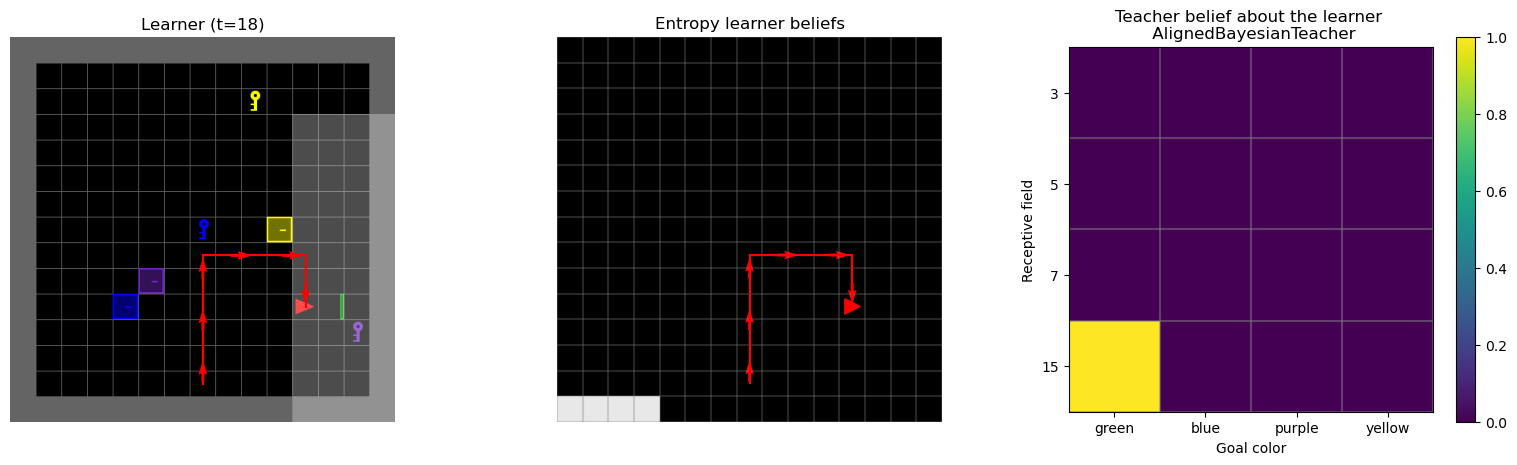

In [3]:
GRID_SIZE = 15

receptive_field = 15
goal_color = 0

learner = BayesianLearner(
    goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE
)  # , save_render=True)
teacher = AlignedBayesianTeacher(env=learner.env)
print(teacher.rf_values)
images = display_learner_play_teacher_infer(GRID_SIZE, learner, teacher)

## Save gif
# gif_file = f"./outputs_rendering/bug/rendering_rf_{receptive_field}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

In [ ]:
# Debugging
save_LOG("./outputs_rendering/bug/LOG_teacher.csv", teacher)
save_LOG("./outputs_rendering/bug/LOG_learner.csv", learner)

#### Satistics on the ToM model
- The teacher observes the entire episode (i.e. until the learner finishes the task)
- The ambiguity at the end of the episode is on the size of the receptive field
    - The evaluation metric of the ToM model is the accuracy on the size of the receptive field of the MAP}}$ of the teacher beliefs

In [ ]:
grid_size_values = [11, 15, 21, 25]

DICT = {}
N = 200

In [ ]:
# Progress bar
print(f"Progress aligned Bayesian teacher:", end="\n")
pbar = progressbar.ProgressBar(
    maxval=len(grid_size_values) * len(RF_VALUES) * num_colors * N
).start()
nn = 0

for kk, GRID_SIZE in enumerate(grid_size_values):
    dict = {}

    rf_values = np.array(rf_values_basic + [GRID_SIZE])

    for rf_idx, receptive_field in enumerate(rf_values):
        dict[receptive_field] = {}
        for goal_color in range(num_colors):
            dict[receptive_field][goal_color] = {}

            dict[receptive_field][goal_color]["accuracy"] = {}
            dict[receptive_field][goal_color]["accuracy"]["goal"] = []
            dict[receptive_field][goal_color]["accuracy"]["rf"] = []

            dict[receptive_field][goal_color]["length"] = []
            dict[receptive_field][goal_color]["beliefs"] = []
            for _ in range(N):
                learner = BayesianLearner(
                    goal_color=goal_color,
                    receptive_field=receptive_field,
                    grid_size=GRID_SIZE,
                )
                teacher = AlignedBayesianTeacher(env=learner.env)

                ii = 0
                while not learner.terminated:  # and ii < 1:
                    # Interaction
                    agent_pos = learner.env.agent_pos
                    agent_dir = learner.env.agent_dir
                    teacher.update_knowledge(
                        learner_pos=agent_pos,
                        learner_dir=agent_dir,
                        learner_step_count=ii,
                    )
                    traj = learner.play(size=1)
                    teacher.observe(action=traj[0])

                    assert not np.isnan(teacher.beliefs[0, 0])

                    ii += 1

                argmax_set = np.where(teacher.beliefs == np.max(teacher.beliefs))
                argmax_idx = np.random.choice(len(argmax_set[0]))
                argmax = np.array(
                    [argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]]
                )

                dict[receptive_field][goal_color]["accuracy"]["goal"].append(
                    goal_color == argmax[0]
                )
                dict[receptive_field][goal_color]["accuracy"]["rf"].append(
                    rf_idx == argmax[1]
                )
                dict[receptive_field][goal_color]["length"].append(ii)
                dict[receptive_field][goal_color]["beliefs"].append(teacher.beliefs)

                # Progress bar
                nn += 1
                pbar.update(nn)

    DICT[GRID_SIZE] = dict

    # Save dict
    with open(f"./stats/20.07.2023/aligned/stats_outputs_aligned.pickle", "wb") as f:
        pickle.dump(DICT, f)

In [ ]:
# Debugging
save_LOG("./outputs_rendering/bug/LOG_teacher.csv", teacher)
save_LOG("./outputs_rendering/bug/LOG_learner.csv", learner)

### Teacher knowing rational learner
 - Greedy: get closer to the object (goal or subgoal)
 - Exploration: uniform on the mouvement actions

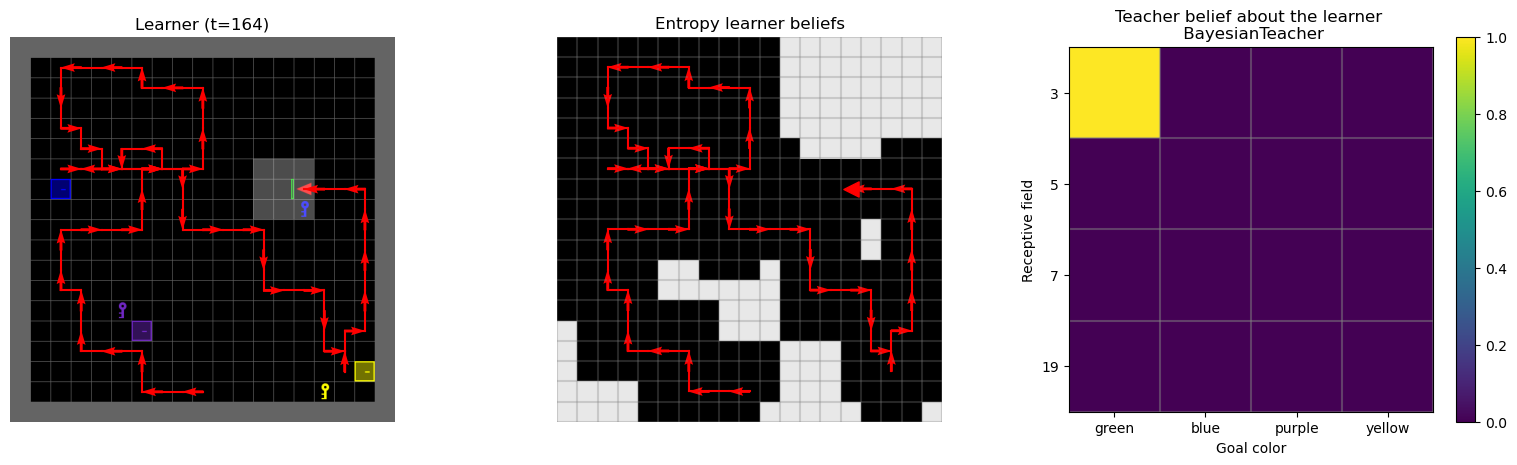

In [3]:
from IPython.display import clear_output
from PIL import Image

GRID_SIZE = 19

receptive_field = 3
goal_color = 0
lambd = 0.1

learner = BayesianLearner(
    goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE
)  # , save_render=True)
teacher = BayesianTeacher(env=learner.env, lambd=lambd)

images = display_learner_play_teacher_infer(GRID_SIZE, learner, teacher)

In [ ]:
# Debugging
save_LOG("./outputs_rendering/bug/LOG_teacher.csv", teacher)
save_LOG("./outputs_rendering/bug/LOG_learner.csv", learner)

### Stats
* Varying goals
* Constant receptive field

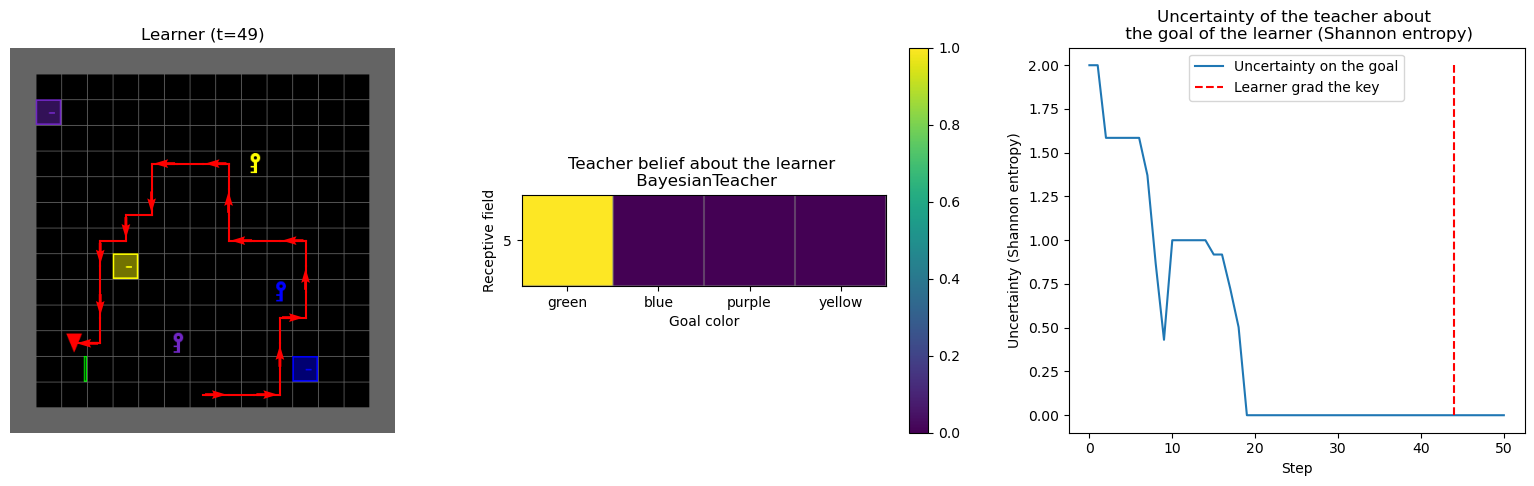

In [6]:
from IPython.display import clear_output
from PIL import Image

GRID_SIZE = 15

receptive_field = 5
goal_color = 0
lambd = 0.1

learner = BayesianLearner(
    goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE
)  # , save_render=True)
# teacher = BayesianTeacher(env=learner.env, lambd=lambd, add_full_obs=True)
teacher = BayesianTeacher(
    env=learner.env, lambd=lambd, rf_values=[receptive_field], add_full_obs=False
)


images = display_learner_play_teacher_infer_blind_with_uncertainty(learner, teacher)

In [34]:
# Save gif
gif_file = f"./outputs_rendering/ToM_only_goal/goal_{IDX_TO_COLOR[goal_color+1]}_rf_{receptive_field}_interpretation_8.gif"
images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

In [142]:
grid_size_values = [15]
lambd_values = [0.01, 0.5, 1.0, 3.0, 10.0]

N = 200

In [126]:
DICT = {}

# Progress bar
# print(f'Progress lambda={lambd}:', end='\n')
pbar = progressbar.ProgressBar(maxval=len(grid_size_values) * num_colors * N).start()
nn = 0

for kk, GRID_SIZE in enumerate(grid_size_values):
    dict = {}

    rf_values = [5]

    for rf_idx, receptive_field in enumerate(rf_values):
        dict[receptive_field] = {}
        for goal_color in range(num_colors):
            dict[receptive_field][goal_color] = {}

            for lambd in lambd_values:
                dict[receptive_field][goal_color][lambd] = {}
                dict[receptive_field][goal_color][lambd]["accuracy"] = {}
                dict[receptive_field][goal_color][lambd]["accuracy"]["goal"] = []
                dict[receptive_field][goal_color][lambd]["length"] = []
                dict[receptive_field][goal_color][lambd]["beliefs"] = []

            dict[receptive_field][goal_color]["aligned"] = {}
            dict[receptive_field][goal_color]["aligned"]["accuracy"] = {}
            dict[receptive_field][goal_color]["aligned"]["accuracy"]["goal"] = []
            dict[receptive_field][goal_color]["aligned"]["length"] = []
            dict[receptive_field][goal_color]["aligned"]["beliefs"] = []

            for _ in range(N):
                learner = BayesianLearner(
                    goal_color=goal_color,
                    receptive_field=receptive_field,
                    grid_size=GRID_SIZE,
                )
                teachers = [
                    BayesianTeacher(
                        env=learner.env,
                        lambd=lambd,
                        rf_values=rf_values,
                        add_full_obs=False,
                    )
                    for lambd in lambd_values
                ]
                aligned_teacher = AlignedBayesianTeacher(
                    env=learner.env, rf_values=rf_values, add_full_obs=False
                )

                ii = 0

                # Stat on Bayesian teacher (approcimative policy)
                for tt, teacher in enumerate(teachers):
                    lambd = lambd_values[tt]

                    argmax_set = np.where(teacher.beliefs == np.max(teacher.beliefs))
                    argmax_idx = np.random.choice(len(argmax_set[0]))
                    argmax = np.array(
                        [argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]]
                    )

                    dict[receptive_field][goal_color][lambd]["accuracy"]["goal"].append(
                        goal_color == argmax[0]
                    )
                    dict[receptive_field][goal_color][lambd]["beliefs"].append(
                        teacher.beliefs.copy()
                    )
                    dict[receptive_field][goal_color][lambd]["length"].append(ii)

                # Stat on Aligned teacher (exact policy)
                argmax_set = np.where(
                    aligned_teacher.beliefs == np.max(aligned_teacher.beliefs)
                )
                argmax_idx = np.random.choice(len(argmax_set[0]))
                argmax = np.array(
                    [argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]]
                )

                dict[receptive_field][goal_color]["aligned"]["accuracy"]["goal"].append(
                    goal_color == argmax[0]
                )
                dict[receptive_field][goal_color]["aligned"]["beliefs"].append(
                    aligned_teacher.beliefs.copy()
                )
                dict[receptive_field][goal_color]["aligned"]["length"].append(ii)

                # End the experiment when the learner has reached the goal
                while learner.env.carrying is None:
                    # Interaction
                    agent_pos = learner.env.agent_pos
                    agent_dir = learner.env.agent_dir
                    for teacher in teachers:
                        teacher.update_knowledge(
                            learner_pos=agent_pos,
                            learner_dir=agent_dir,
                            learner_step_count=ii,
                        )
                    aligned_teacher.update_knowledge(
                        learner_pos=agent_pos,
                        learner_dir=agent_dir,
                        learner_step_count=ii,
                    )

                    traj = learner.play(size=1)
                    assert not np.isnan(teacher.beliefs[0, 0])

                    ii += 1

                    # Stat on Bayesian teacher (approcimative policy)
                    for tt, teacher in enumerate(teachers):
                        teacher.observe(traj[0])
                        lambd = lambd_values[tt]

                        argmax_set = np.where(
                            teacher.beliefs == np.max(teacher.beliefs)
                        )
                        argmax_idx = np.random.choice(len(argmax_set[0]))
                        argmax = np.array(
                            [argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]]
                        )

                        dict[receptive_field][goal_color][lambd]["accuracy"][
                            "goal"
                        ].append(goal_color == argmax[0])
                        dict[receptive_field][goal_color][lambd]["beliefs"].append(
                            teacher.beliefs.copy()
                        )
                        dict[receptive_field][goal_color][lambd]["length"].append(ii)

                    # Stat on Aligned teacher (exact policy)
                    aligned_teacher.observe(traj[0])
                    argmax_set = np.where(
                        aligned_teacher.beliefs == np.max(aligned_teacher.beliefs)
                    )
                    argmax_idx = np.random.choice(len(argmax_set[0]))
                    argmax = np.array(
                        [argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]]
                    )

                    dict[receptive_field][goal_color]["aligned"]["accuracy"][
                        "goal"
                    ].append(goal_color == argmax[0])
                    dict[receptive_field][goal_color]["aligned"]["beliefs"].append(
                        aligned_teacher.beliefs.copy()
                    )
                    dict[receptive_field][goal_color]["aligned"]["length"].append(ii)

                # Progress bar
                nn += 1
                pbar.update(nn)

    DICT[GRID_SIZE] = dict

    # Save dict
    with open(f"./stats_goal/10.08.2023/stats_outputs_goal.pickle", "wb") as f:
        pickle.dump(DICT, f)

In [128]:
load_filename = f"./stats_goal/10.08.2023/stats_outputs_goal.pickle"
with open(load_filename, "rb") as f:
    DICT = pickle.load(f)

In [131]:
receptive_field = 5
GRID_SIZE = 15
N = 200 * 4

for lambd in lambd_values:
    all_length = []
    all_acc = []
    for goal_color in range(num_colors):
        all_length += DICT[GRID_SIZE][receptive_field][goal_color][lambd]["length"]
        all_acc += DICT[GRID_SIZE][receptive_field][goal_color][lambd]["accuracy"][
            "goal"
        ]

    max_length = np.max(all_length)

    hist = np.zeros(np.max(all_length))
    n = np.zeros(np.max(all_length))

    for i in range(0, max_length):
        idx = np.where(np.array(all_length) == i)[0]
        hist[i] += np.sum(np.array(all_acc)[idx])
        n[i] = len(idx)

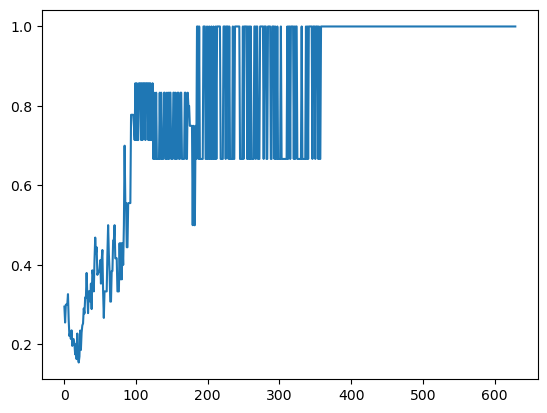

In [102]:
plt.plot(hist / n)

In [143]:
receptive_fiel = 5
GRID_SIZE = 15
N = 200 * 4

all_hist = {}
all_hist_entropy = {}

for lambd in lambd_values + ["aligned"]:
    all_length = []
    all_acc = []
    all_beliefs = []

    for goal_color in range(num_colors):
        all_length += DICT[GRID_SIZE][receptive_field][goal_color][lambd]["length"]
        all_acc += DICT[GRID_SIZE][receptive_field][goal_color][lambd]["accuracy"][
            "goal"
        ]
        all_beliefs += DICT[GRID_SIZE][receptive_field][goal_color][lambd]["beliefs"]

    hist = np.zeros((101, N))
    hist_entropy = np.zeros((101, N))

    begin_episode = np.where(np.array(all_length) == 0)[0]

    for n in range(N):
        start = begin_episode[n]
        if n < (N - 1):
            end = begin_episode[n + 1]
        else:
            end = len(all_length)

        acc = np.array(all_acc)[start:end]
        length = np.array(all_length)[start:end]
        beliefs = np.array(all_beliefs)[start:end]

        for i in range(0, 101, 2):
            idx_pour = int(length[-1] * i / 100)
            hist[i, n] = acc[idx_pour]
            hist_entropy[i, n] = Shannon_entropy(beliefs[idx_pour])

    all_hist[lambd] = hist
    all_hist_entropy[lambd] = hist_entropy

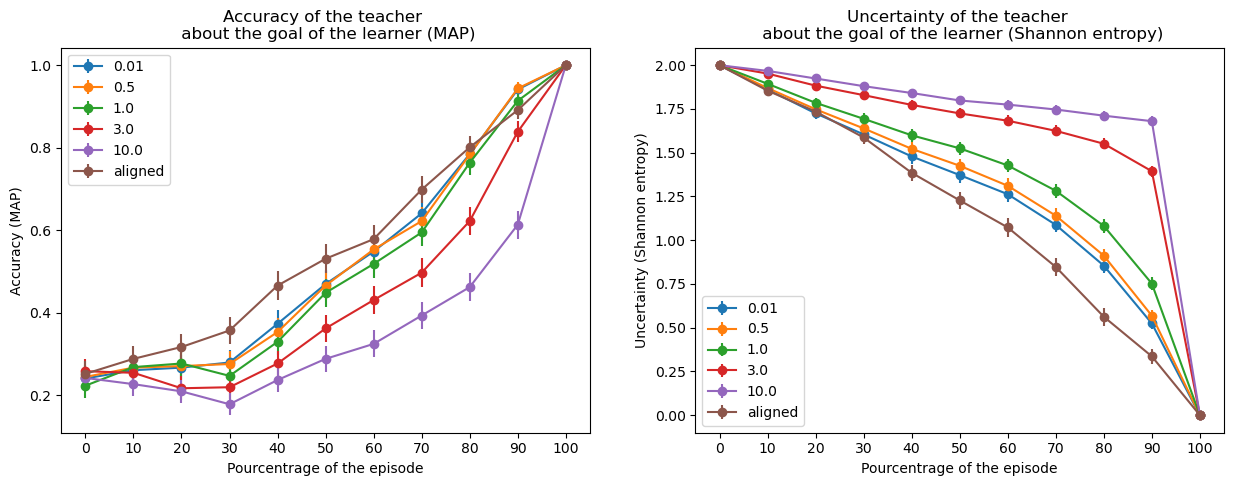

In [152]:
idx = np.arange(0, 101, 10)

colors = []
fig = plt.figure(figsize=(15, 5))

fig.add_subplot(1, 2, 1)
for lambd in lambd_values + ["aligned"]:
    hist = all_hist[lambd]
    plt.errorbar(
        idx,
        np.mean(hist[idx], axis=1),
        yerr=1.96 * np.std(hist[idx], axis=1) / np.sqrt(N),
        marker="o",
        label=lambd,
    )
    plt.legend()
plt.title("Accuracy of the teacher \n about the goal of the learner (MAP)")
plt.xlabel("Pourcentrage of the episode")
plt.ylabel("Accuracy (MAP)")
plt.xticks(idx)

fig.add_subplot(1, 2, 2)
for lambd in lambd_values + ["aligned"]:
    hist_entropy = all_hist_entropy[lambd]
    plt.errorbar(
        idx,
        np.mean(hist_entropy[idx], axis=1),
        yerr=1.96 * np.std(hist_entropy[idx], axis=1) / np.sqrt(N),
        marker="o",
        label=lambd,
    )
    plt.legend()
plt.title(
    "Uncertainty of the teacher \n about the goal of the learner (Shannon entropy)"
)
plt.xlabel("Pourcentrage of the episode")
plt.ylabel("Uncertainty (Shannon entropy)")
plt.xticks(idx);

### Stats when observing a entire episode --> remove ambiguity on the goal
* Varying goals
* Varying receptive fields

In [153]:
grid_size_values = [11, 15, 21, 25]
lamd_values = [0.01, 0.5, 1.0, 3.0, 10.0]

N = 1

In [163]:
DICT = {}
for lambd in lambd_values + ["aligned"]:
    DICT[lambd] = {}

# Progress bar
pbar = progressbar.ProgressBar(
    maxval=len(grid_size_values) * len(RF_VALUES) * num_colors * N
).start()
nn = 0

for kk, GRID_SIZE in enumerate(grid_size_values):
    dict = {}
    for lambd in lamd_values + ["aligned"]:
        dict[lambd] = {}

    rf_values = np.array(rf_values_basic + [GRID_SIZE])

    for rf_idx, receptive_field in enumerate(rf_values):
        for lambd in lamd_values + ["aligned"]:
            dict[lambd][receptive_field] = {}

        for goal_color in range(num_colors):
            for lambd in lamd_values + ["aligned"]:
                dict[lambd][receptive_field][goal_color] = {}

                dict[lambd][receptive_field][goal_color]["accuracy"] = {}
                dict[lambd][receptive_field][goal_color]["accuracy"]["goal"] = []
                dict[lambd][receptive_field][goal_color]["accuracy"]["rf"] = []

                dict[lambd][receptive_field][goal_color]["length"] = []
                dict[lambd][receptive_field][goal_color]["beliefs"] = []

            for _ in range(N):
                learner = BayesianLearner(
                    goal_color=goal_color,
                    receptive_field=receptive_field,
                    grid_size=GRID_SIZE,
                )
                teachers = [
                    BayesianTeacher(env=learner.env, lambd=lambd)
                    for lambd in lambd_values
                ]
                aligned_teacher = AlignedBayesianTeacher(env=learner.env)

                ii = 0
                while not learner.terminated:  # and ii < 1:
                    # Interaction
                    agent_pos = learner.env.agent_pos
                    agent_dir = learner.env.agent_dir

                    for teacher in teachers:
                        teacher.update_knowledge(
                            learner_pos=agent_pos,
                            learner_dir=agent_dir,
                            learner_step_count=ii,
                        )
                    aligned_teacher.update_knowledge(
                        learner_pos=agent_pos,
                        learner_dir=agent_dir,
                        learner_step_count=ii,
                    )

                    traj = learner.play(size=1)

                    for teacher in teachers:
                        teacher.observe(action=traj[0])
                    aligned_teacher.observe(action=traj[0])

                    assert not np.isnan(teacher.beliefs[0, 0])

                    ii += 1

                for tt, teacher in enumerate(teachers):
                    lambd = lambd_values[tt]

                    argmax_set = np.where(teacher.beliefs == np.max(teacher.beliefs))
                    argmax_idx = np.random.choice(len(argmax_set[0]))
                    argmax = np.array(
                        [argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]]
                    )

                    dict[lambd][receptive_field][goal_color]["accuracy"]["goal"].append(
                        goal_color == argmax[0]
                    )
                    dict[lambd][receptive_field][goal_color]["accuracy"]["rf"].append(
                        rf_idx == argmax[1]
                    )
                    dict[lambd][receptive_field][goal_color]["length"].append(ii)
                    dict[lambd][receptive_field][goal_color]["beliefs"].append(
                        teacher.beliefs
                    )

                # Stat on aligned teacher
                argmax_set = np.where(
                    aligned_teacher.beliefs == np.max(aligned_teacher.beliefs)
                )
                argmax_idx = np.random.choice(len(argmax_set[0]))
                argmax = np.array(
                    [argmax_set[0][argmax_idx], argmax_set[1][argmax_idx]]
                )

                dict["aligned"][receptive_field][goal_color]["accuracy"]["goal"].append(
                    goal_color == argmax[0]
                )
                dict["aligned"][receptive_field][goal_color]["accuracy"]["rf"].append(
                    rf_idx == argmax[1]
                )
                dict["aligned"][receptive_field][goal_color]["length"].append(ii)
                dict["aligned"][receptive_field][goal_color]["beliefs"].append(
                    aligned_teacher.beliefs
                )

                # Progress bar
                nn += 1
                pbar.update(nn)

    # Save dict
    for lambd in lambd_values + ["aligned"]:
        DICT[lambd][GRID_SIZE] = dict[lambd]

        save_filename = f"./stats/10.08.2023/lambda_{lambd}"
        make_dirs(save_filename)
        with open(save_filename + f"/stats_outputs_lambd_{lambd}.pickle", "wb") as f:
            pickle.dump(DICT[lambd], f)

#### Display ToM model analysis

In [162]:
date = "10.08.2023"
# lambd = 0.1
# GRID_SIZE = 11

# Parameters for display
for lambd in lamd_values + ["aligned"]:
    for GRID_SIZE in grid_size_values:
        load_filename = (
            f"./stats/{date}/lambda_{lambd}/stats_outputs_lambd_{lambd}.pickle"
        )
        save_filename = (
            f"./stats/{date}/lambda_{lambd}/analysis_gridsize_{GRID_SIZE}.png"
        )

        display_ToM_hist(GRID_SIZE, load_filename, save_filename, N, lambd)

        save_filename = f"./stats/{date}/lambda_{lambd}/all_acc_lambda_{lambd}.png"
        display_ToM_errorbar(load_filename, save_filename, lambd)

FileNotFoundError: [Errno 2] No such file or directory: './stats/10.08.2023/lambda_0.01/stats_outputs_lambd_0.01.pickle'

### Display all ToM models performances (RF-accuracy MAP)

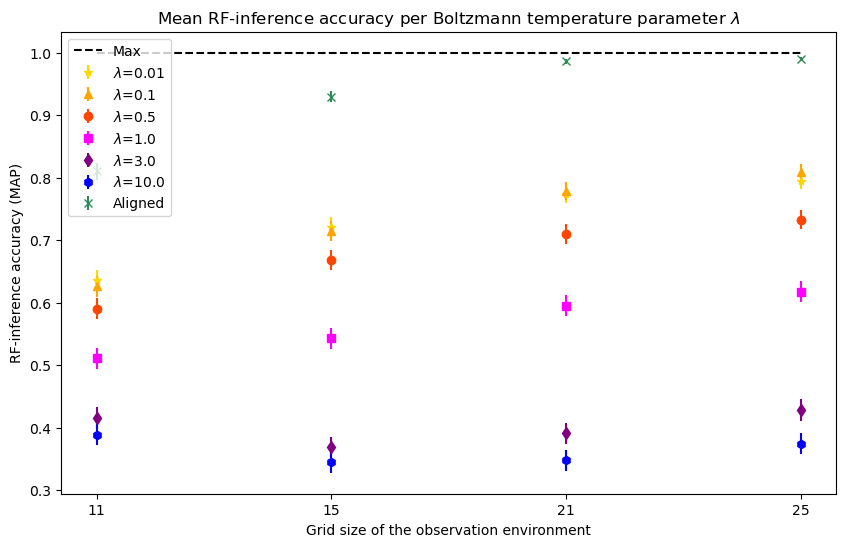

In [4]:
display_all_ToM("20.07.2023", lamd_values, grid_size_values)

In [ ]:
dict = {}
N = 100

# for GRID_SIZE in grid_size_values:
dict[GRID_SIZE_DEMO] = {}

rf_values = rf_values_basic + [GRID_SIZE_DEMO]

all_length = [[] for _ in rf_values]

for rf_idx, rf in enumerate(rf_values):
    for goal_color in trange(num_colors):
        for _ in range(N):
            # Generate new feasible env
            learner = BayesianLearner(
                goal_color=goal_color,
                receptive_field=rf,
                grid_size=GRID_SIZE_DEMO,
                env_type="MultiRoomsGoalsEnv",
            )
            env = learner.env

            traj = generate_demo(env, rf, goal_color)
            all_length[rf_idx].append(len(traj))

mean_all = [np.mean(length) for length in all_length]
std_all = [np.std(length) for length in all_length]

dict[GRID_SIZE]["mean"] = mean_all
dict[GRID_SIZE]["std"] = std_all

In [ ]:
grid_size_values = [GRID_SIZE_DEMO]
mean_std_length = np.zeros((len(grid_size_values), len(rf_values))).astype(str)

for gg, GRID_SIZE in enumerate(grid_size_values):
    for ii, rf in enumerate(rf_values):
        mean = dict[GRID_SIZE]["mean"][ii]
        std = dict[GRID_SIZE]["std"][ii]
        mean_std_length[gg, ii] = (
            str(np.round(mean, 4))
            + " +/- "
            + str(np.round(1.96 * std / np.sqrt(N * num_colors), 4))
        )

pd.DataFrame(
    mean_std_length, columns=(rf_values_basic + ["full_obs"]), index=grid_size_values
)

## Showing the demonstration

In [3]:
GRID_SIZE = 21
GRID_SIZE_DEMO = 45

print(
    f"MultiGoalsEnv observation nvironment: \n \
      GRID_SIZE {GRID_SIZE}\n \
      (max_steps={GRID_SIZE**2}) \n"
)

print(
    f"MultiRoomsGoalsEnv demonstration environment: \n \
      GRID_SIZE {GRID_SIZE_DEMO}\n \
      (max_steps={GRID_SIZE_DEMO**2/2}) \n"
)

idx = 1
receptive_field = RF_VALUES[idx]
goal_color = 0
print(
    f"Leaner: \n \
      rf={receptive_field} \n \
      goal_color={IDX_TO_COLOR[goal_color+1]} \n"
)

lambd = 0.1
print(
    f"Teacher: \n \
      Boltzmann temperatire lambda={lambd}"
)

rf_values_basic = [3, 5, 7]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

MultiGoalsEnv observation nvironment: 
       GRID_SIZE 21
       (max_steps=441) 

MultiRoomsGoalsEnv demonstration environment: 
       GRID_SIZE 45
       (max_steps=1012.5) 

Leaner: 
       rf=5 
       goal_color=green 

Teacher: 
       Boltzmann temperatire lambda=0.1


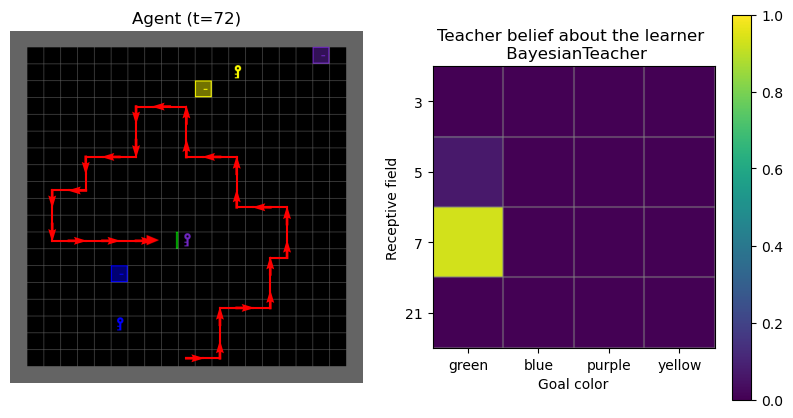

In [6]:
# Teacher observes the learner and fit his model

learner = BayesianLearner(
    goal_color=goal_color, receptive_field=receptive_field, grid_size=GRID_SIZE
)  # , save_render=True)
teacher = BayesianTeacher(env=learner.env, lambd=lambd)

images = display_learner_play_teacher_infer_blind(learner, teacher)

# gif_file = f"./outputs_rendering/demonstrations/example_1/observation_rf_{receptive_field}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

In [ ]:
learner = BayesianLearner(
    goal_color=goal_color,
    receptive_field=receptive_field,
    grid_size=GRID_SIZE_DEMO,
    env_type="MultiRoomsGoalsEnv",
)
teacher.init_env(learner.env)

selected_demo, _, _, _ = teacher.select_demo()

In [ ]:
# Display demonstration and learner beliefs update

learner.observe(selected_demo)
images = display_learner_obs_demo(GRID_SIZE_DEMO, learner)

# gif_file = f"./outputs_rendering/demonstrations/example_1/demo_rf_{rf_values[demo_idx]}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

In [ ]:
# Display learner playing after observing the demo

images = display_learner_play(GRID_SIZE_DEMO, learner, size=15)
print(f"Reward: {learner.reward:.4f}")

# gif_file = f"./outputs_rendering/demonstrations/example_1/play_after_demo_rf_{rf_values[demo_idx]}.gif"
# images[0].save(gif_file, save_all=True, append_images=images[1:], duration=200, loop=0)

### Statistics on the utility

In [ ]:
N = 200
goal_color = 0

#### Stats on the predicted reward by the teachers of the learner after seen the demo on the $\mathbf{complex \text{ } env}$

In [ ]:
all_reward = {}  # np.zeros((len(rf_values), len(rf_values)))

for rf_idx, receptive_field in enumerate(RF_VALUES_DEMO):
    for demo_idx, demo_rf in enumerate(RF_VALUES_DEMO):
        all_reward[rf_idx, demo_idx] = []

for _ in trange(N):
    learner = BayesianLearner(
        goal_color=goal_color,
        receptive_field=RF_VALUES_DEMO[0],
        grid_size=GRID_SIZE_DEMO,
        env_type="MultiRoomsGoalsEnv",
        max_steps=int(GRID_SIZE_DEMO**2 / 2),
    )
    teacher = AlignedBayesianTeacher(learner.env)
    for rf_idx, receptive_field in enumerate(RF_VALUES_DEMO):
        for demo_idx, demo_rf in enumerate(RF_VALUES_DEMO):
            # Reset env
            learner.reset()
            learner.change_receptive_field(receptive_field)

            # Generate demo for predicted rf demo_rf (right goal_color)
            demo = generate_demo(learner.env, demo_rf, goal_color)

            pred_reward = teacher.predicted_reward(demo, goal_color, rf_idx)

            all_reward[rf_idx, demo_idx].append(pred_reward)

In [ ]:
all_reward_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))

for rf_idx, rf in enumerate(RF_VALUES_DEMO):
    for demo_idx, rf_demo in enumerate(RF_VALUES_DEMO):
        all_reward_mean[rf_idx, demo_idx] = np.mean(all_reward[rf_idx, demo_idx])

save_filename = f"./stats/reward/predicted_reward_{teacher.__class__.__name__}.pickle"
with open(save_filename, "wb") as f:
    pickle.dump(all_reward_mean, f)

In [ ]:
load_filename = f"./stats/reward/predicted_reward_{teacher.__class__.__name__}.pickle"

with open(load_filename, "rb") as f:
    all_reward_mean = pickle.load(f)

In [ ]:
fig = plt.figure(figsize=(10, 8))

image = plt.imshow(all_reward_mean, cmap="magma")
plt.colorbar(image)
plt.xticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ["full_obs"])
plt.yticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ["full_obs"])
plot_grid(-0.5, 5, 3.5)
plt.title(
    f"Mean predicted reward from the {teacher.__class__.__name__} \n of the learners after seen the demonstrations"
)  # \n lambda={lambd}')
plt.ylabel("Learner receptive field")
plt.xlabel("Demonstration for receptive field")


fig.suptitle(f"GRID_SIZE_DEMO={GRID_SIZE_DEMO}");

#### Stats on the true utility --> run of the learner

In [ ]:
all_steps_count = {}  # np.zeros((len(rf_values), len(rf_values)))
all_reward = {}  # np.zeros((len(rf_values), len(rf_values)))
all_length = {}  # np.zeros((len(rf_values), len(rf_values)))

for rf_idx, receptive_field in enumerate(RF_VALUES_DEMO):
    for demo_idx, demo_rf in enumerate(RF_VALUES_DEMO):
        all_steps_count[rf_idx, demo_idx] = []
        all_reward[rf_idx, demo_idx] = []
        all_length[rf_idx, demo_idx] = []

for _ in trange(N):
    learner = BayesianLearner(
        goal_color=goal_color,
        receptive_field=RF_VALUES_DEMO[0],
        grid_size=GRID_SIZE_DEMO,
        env_type="MultiRoomsGoalsEnv",
        max_steps=int(GRID_SIZE_DEMO**2 / 2),
    )
    for rf_idx, receptive_field in enumerate(RF_VALUES_DEMO):
        for demo_idx, demo_rf in enumerate(RF_VALUES_DEMO):
            # Reset env
            learner.reset()
            learner.change_receptive_field(receptive_field)

            # Generate demo for predicted rf demo_rf (right goal_color)
            demo = generate_demo(learner.env, demo_rf, goal_color)

            # Learner observes the demonstration
            learner.observe(demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after observing the demo
            learner.play()

            all_steps_count[rf_idx, demo_idx].append(learner.env.step_count)
            all_reward[rf_idx, demo_idx].append(learner.reward)
            all_length[rf_idx, demo_idx].append(len(demo))

In [ ]:
DICT_DEMO = dict(
    all_length=all_length, all_reward=all_reward, all_steps_count=all_steps_count
)

save_filename = (
    f"./stats/true_utility/stats_outputs_complex_env_without_exploration_goal.pickle"
)
with open(save_filename, "wb") as f:
    pickle.dump(DICT_DEMO, f)

In [ ]:
# Load dico

load_filename = (
    f"./stats/true_utility/stats_outputs_complex_env_without_exploration_goal.pickle"
)
with open(load_filename, "rb") as f:
    DICT_DEMO = pickle.load(f)

In [ ]:
all_steps_count_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))
all_length_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))
all_reward_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))
all_utilities_mean = np.zeros((len(RF_VALUES_DEMO), len(RF_VALUES_DEMO)))

alpha = 0.3


def cost(a, norm):
    return alpha * np.exp(-(norm - a) * alpha) - alpha * np.exp(-norm * alpha)


# alpha = 0.15
# def cost(a, norm=None):
#     assert(np.all(a <= norm))
#     return alpha * a / norm

for rf_idx, rf in enumerate(rf_values_demo):
    for demo_idx, rf_demo in enumerate(rf_values_demo):
        all_steps_count_mean[rf_idx, demo_idx] = np.mean(
            DICT_DEMO["all_steps_count"][rf_idx, demo_idx]
        )

        n = 0

        all_reward_mean[rf_idx, demo_idx] = np.mean(
            DICT_DEMO["all_reward"][rf_idx, demo_idx][:N]
        )
        all_length_mean[rf_idx, demo_idx] = np.mean(
            DICT_DEMO["all_length"][rf_idx, demo_idx][:N]
        )

        norm = np.max(
            np.array(
                [
                    DICT_DEMO["all_length"][rf_idx, ii][:N]
                    for ii, _ in enumerate(rf_values_demo)
                ]
            ),
            axis=0,
        )
        all_utilities_mean[rf_idx, demo_idx] = np.mean(
            np.array(DICT_DEMO["all_reward"][rf_idx, demo_idx][:N])
            - cost(np.array(DICT_DEMO["all_length"][rf_idx, demo_idx][:N]), norm)
        )

In [ ]:
for rf_idx, rf in enumerate(rf_values_demo):
    score = 0
    for n in range(N):
        # n = sample
        norm = np.max(
            np.array(
                [
                    DICT_DEMO["all_length"][rf_idx, ii][n]
                    for ii, _ in enumerate(rf_values_demo)
                ]
            )
        )
        utility = np.array(
            [
                DICT_DEMO["all_reward"][rf_idx, ii][n]
                - cost(np.array(DICT_DEMO["all_length"][rf_idx, ii][n]), norm)
                for ii, _ in enumerate(rf_values_demo)
            ]
        )

        argmax_idx = np.argmax(utility)
        score += argmax_idx == rf_idx

    score /= N
    print(f"rf={rf} --> score {score}")

In [ ]:
fig = plt.figure(figsize=(25, 8))

fig.add_subplot(1, 3, 1)
image = plt.imshow(all_steps_count_mean, cmap="seismic")
plt.colorbar(image)
plt.xticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ["full_obs"])
plt.yticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ["full_obs"])
plot_grid(-0.5, 5, 3.5)
plt.title(
    "Mean number of steps for the learners \n to finish the task after seen the demonstration"
)
plt.ylabel("Learner receptive field")
plt.xlabel("Demonstration for receptive field")

fig.add_subplot(1, 3, 2)
image = plt.imshow(all_reward_mean, cmap="seismic")
plt.colorbar(image)
plt.xticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ["full_obs"])
plt.yticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ["full_obs"])
plot_grid(-0.5, 5, 3.5)
plt.title("Mean reward of the learners \n after seen the demonstrations")
plt.ylabel("Learner receptive field")
plt.xlabel("Demonstration for receptive field")

fig.add_subplot(1, 3, 3)
image = plt.imshow(all_utilities_mean, cmap="seismic")
plt.colorbar(image)
plt.xticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ["full_obs"])
plt.yticks(range(0, len(RF_VALUES_DEMO)), rf_values_basic + ["full_obs"])
plot_grid(-0.5, 5, 3.5)
plt.title(
    f"Mean utility of the demonstrations for the learners \n" + rf"$\alpha$={alpha}"
)
plt.ylabel("Learner receptive field")
plt.xlabel("Demonstration for receptive field")


fig.suptitle(f"GRID_SIZE_DEMO={GRID_SIZE_DEMO}");

In [ ]:
np.round(all_utilities_mean, 4)

In [ ]:
all_reward_mean

In [ ]:
all_length_mean

#### Cost functions

In [ ]:
display_cost(linear)

In [ ]:
display_cost(norm_linear_cost)

In [ ]:
display_cost(exp_cost)

### Statistics on the utility of the teachers - Rationality Principle based / Aligned

In [ ]:
GRID_SIZE = 21
GRID_SIZE_DEMO = 45

print(
    f"MultiGoalsEnv observation nvironment: \n \
      GRID_SIZE {GRID_SIZE}\n \
      (max_steps={GRID_SIZE**2}) \n"
)

print(
    f"MultiRoomsGoalsEnv demonstration environment: \n \
      GRID_SIZE {GRID_SIZE_DEMO}\n \
      (max_steps={GRID_SIZE_DEMO**2/2}) \n"
)

lambd = 0.01

idx = 1
receptive_field = RF_VALUES[idx]
goal_color = 0
print(
    f"Leaner: \n \
      rf={receptive_field} \n \
      goal_color={IDX_TO_COLOR[goal_color+1]} \n"
)

print(
    f"Teacher: \n \
      Boltzmann temperatire lambda={lambd}"
)

rf_values_basic = [3, 5, 7]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

In [ ]:
N = 200

In [ ]:
alpha = 0.3


def cost_fun(x: int, l: int) -> float:
    assert l - x >= 0
    return exp_cost(l - x, l, alpha=alpha)


save_filename = f"./outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_exp_cost_{alpha}.pickle"

DICT_UTIL = {}
DICT_UTIL[lambd] = {}
DICT_UTIL["omniscient"] = {}
DICT_UTIL["aligned"] = {}
DICT_UTIL["opt_non_adaptive"] = {}

for rf_idx, receptive_field in enumerate(rf_values):
    for goal_color in range(num_colors):
        DICT_UTIL[lambd][goal_color, receptive_field] = []
        DICT_UTIL["aligned"][goal_color, receptive_field] = []
        DICT_UTIL["omniscient"][goal_color, receptive_field] = []
        DICT_UTIL["opt_non_adaptive"][goal_color, receptive_field] = []

        for _ in trange(N):
            # print(f'Learner: rf={receptive_field} goal_color={IDX_TO_COLOR[goal_color+1]}')
            # Test teacher utility
            learner = BayesianLearner(
                goal_color=goal_color,
                receptive_field=receptive_field,
                grid_size=GRID_SIZE,
                env_type="MultiGoalsEnv",
            )
            teacher = BayesianTeacher(env=learner.env, lambd=lambd)
            aligned_teacher = AlignedBayesianTeacher(env=learner.env)

            # Teacher observes the learner during one full episode on the first simple env
            ii = 0
            while not learner.terminated:
                agent_pos = learner.env.agent_pos
                agent_dir = learner.env.agent_dir

                teacher.update_knowledge(
                    learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii
                )
                aligned_teacher.update_knowledge(
                    learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii
                )

                traj = learner.play(size=1)

                teacher.observe(action=traj[0])
                aligned_teacher.observe(action=traj[0])

                ii += 1

            # Teacher use ToM to predict the utility of each demo for this particular learner --> select the more relevant demo
            learner = BayesianLearner(
                goal_color=goal_color,
                receptive_field=rf_values_demo[rf_idx],
                grid_size=GRID_SIZE_DEMO,
                env_type="MultiRoomsGoalsEnv",
            )

            ## Rationality principle teacher
            teacher.init_env(learner.env)
            (
                selected_demo,
                demo_idx,
                predicted_best_utility,
                demos,
            ) = teacher.select_demo(cost_fun)

            l_max = np.max([len(demo) for demo in demos])

            # Learner "observes" the demo
            learner.observe(selected_demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after seen the demo
            _ = learner.play()

            true_utility = learner.reward - cost_fun(len(selected_demo), l_max)

            DICT_UTIL[lambd][goal_color, receptive_field].append(
                (demo_idx, predicted_best_utility, true_utility)
            )
            # print(f'Bayesian teacher: selected demo: {demo_idx} predicted best utility: {predicted_best_utility:.4f} true utility: {true_utility:.4f}')

            ## Aligned teacher
            aligned_teacher.init_env(learner.env)
            (
                aligned_selected_demo,
                aligned_demo_idx,
                aligned_predicted_best_utility,
                _,
            ) = aligned_teacher.select_demo(cost_fun)

            learner.reset()
            # Learner "observes" the demo
            learner.observe(aligned_selected_demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after seen the demo
            _ = learner.play()

            aligned_true_utility = learner.reward - cost_fun(
                len(aligned_selected_demo), l_max
            )

            DICT_UTIL["aligned"][goal_color, receptive_field].append(
                (aligned_demo_idx, aligned_predicted_best_utility, aligned_true_utility)
            )

            # print(f'Aligned teacher: selected demo: {aligned_demo_idx} predicted best utility: {aligned_predicted_best_utility:.4f} true utility: {aligned_true_utility:.4f}')

            ## Omnicient teacher
            true_utilities = []
            for demo in demos:
                # Reset env
                learner.reset()

                # Learner observes the demonstration
                learner.observe(demo)

                # Reset step count in the env
                learner.env.step_count = 0
                # Learner play after observing the demo
                learner.play()

                true_utility = learner.reward - cost_fun(len(demo), l_max)
                true_utilities.append(true_utility)

            true_best_utility = np.max(true_utilities)
            true_demo_idx = np.argmax(true_utilities)

            # print(f'Omniscient: best demo idx {true_demo_idx} true best utility {true_best_utility:.4f}')
            DICT_UTIL["omniscient"][goal_color, receptive_field].append(
                (true_demo_idx, true_best_utility)
            )

            ## Optimal non-adaptive
            DICT_UTIL["opt_non_adaptive"][goal_color, receptive_field].append(
                (0, true_utilities[0])
            )

        with open(save_filename, "wb") as f:
            pickle.dump(DICT_UTIL, f)

In [10]:
GRID_SIZE = 15
GRID_SIZE_DEMO = 45

print(
    f"MultiGoalsEnv observation nvironment: \n \
      GRID_SIZE {GRID_SIZE}\n \
      (max_steps={GRID_SIZE**2}) \n"
)

print(
    f"MultiRoomsGoalsEnv demonstration environment: \n \
      GRID_SIZE {GRID_SIZE_DEMO}\n \
      (max_steps={GRID_SIZE_DEMO**2/2}) \n"
)

lambd = 0.01

idx = 1
receptive_field = RF_VALUES[idx]
goal_color = 0
print(
    f"Leaner: \n \
      rf={receptive_field} \n \
      goal_color={IDX_TO_COLOR[goal_color+1]} \n"
)

print(
    f"Teacher: \n \
      Boltzmann temperatire lambda={lambd}"
)

rf_values_basic = [3, 5, 7]
rf_values = np.array(rf_values_basic + [GRID_SIZE])
rf_values_demo = np.array(rf_values_basic + [GRID_SIZE_DEMO])

MultiGoalsEnv observation nvironment: 
       GRID_SIZE 15
       (max_steps=225) 

MultiRoomsGoalsEnv demonstration environment: 
       GRID_SIZE 45
       (max_steps=1012.5) 

Leaner: 
       rf=5 
       goal_color=green 

Teacher: 
       Boltzmann temperatire lambda=0.01


In [ ]:
alpha = 0.3


def cost_fun(x: int, l: int) -> float:
    assert l - x >= 0
    return exp_cost(l - x, l, alpha=alpha)


save_filename = f"./outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_exp_cost_{alpha}.pickle"

DICT_UTIL = {}
DICT_UTIL[lambd] = {}
DICT_UTIL["omniscient"] = {}
DICT_UTIL["aligned"] = {}
DICT_UTIL["opt_non_adaptive"] = {}

for rf_idx, receptive_field in enumerate(rf_values):
    for goal_color in range(num_colors):
        DICT_UTIL[lambd][goal_color, receptive_field] = []
        DICT_UTIL["aligned"][goal_color, receptive_field] = []
        DICT_UTIL["omniscient"][goal_color, receptive_field] = []
        DICT_UTIL["opt_non_adaptive"][goal_color, receptive_field] = []

        for _ in trange(N):
            # print(f'Learner: rf={receptive_field} goal_color={IDX_TO_COLOR[goal_color+1]}')
            # Test teacher utility
            learner = BayesianLearner(
                goal_color=goal_color,
                receptive_field=receptive_field,
                grid_size=GRID_SIZE,
                env_type="MultiGoalsEnv",
            )
            teacher = BayesianTeacher(env=learner.env, lambd=lambd)
            aligned_teacher = AlignedBayesianTeacher(env=learner.env)

            # Teacher observes the learner during one full episode on the first simple env
            ii = 0
            while not learner.terminated:
                agent_pos = learner.env.agent_pos
                agent_dir = learner.env.agent_dir

                teacher.update_knowledge(
                    learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii
                )
                aligned_teacher.update_knowledge(
                    learner_pos=agent_pos, learner_dir=agent_dir, learner_step_count=ii
                )

                traj = learner.play(size=1)

                teacher.observe(action=traj[0])
                aligned_teacher.observe(action=traj[0])

                ii += 1

            # Teacher use ToM to predict the utility of each demo for this particular learner --> select the more relevant demo
            learner = BayesianLearner(
                goal_color=goal_color,
                receptive_field=rf_values_demo[rf_idx],
                grid_size=GRID_SIZE_DEMO,
                env_type="MultiRoomsGoalsEnv",
            )

            ## Rationality principle teacher
            teacher.init_env(learner.env)
            (
                selected_demo,
                demo_idx,
                predicted_best_utility,
                demos,
            ) = teacher.select_demo(cost_fun)

            l_max = np.max([len(demo) for demo in demos])

            # Learner "observes" the demo
            learner.observe(selected_demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after seen the demo
            _ = learner.play()

            true_utility = learner.reward - cost_fun(len(selected_demo), l_max)

            DICT_UTIL[lambd][goal_color, receptive_field].append(
                (demo_idx, predicted_best_utility, true_utility)
            )
            # print(f'Bayesian teacher: selected demo: {demo_idx} predicted best utility: {predicted_best_utility:.4f} true utility: {true_utility:.4f}')

            ## Aligned teacher
            aligned_teacher.init_env(learner.env)
            (
                aligned_selected_demo,
                aligned_demo_idx,
                aligned_predicted_best_utility,
                _,
            ) = aligned_teacher.select_demo(cost_fun)

            learner.reset()
            # Learner "observes" the demo
            learner.observe(aligned_selected_demo)

            # Reset step count in the env
            learner.env.step_count = 0
            # Learner play after seen the demo
            _ = learner.play()

            aligned_true_utility = learner.reward - cost_fun(
                len(aligned_selected_demo), l_max
            )

            DICT_UTIL["aligned"][goal_color, receptive_field].append(
                (aligned_demo_idx, aligned_predicted_best_utility, aligned_true_utility)
            )

            # print(f'Aligned teacher: selected demo: {aligned_demo_idx} predicted best utility: {aligned_predicted_best_utility:.4f} true utility: {aligned_true_utility:.4f}')

            ## Omnicient teacher
            true_utilities = []
            for demo in demos:
                # Reset env
                learner.reset()

                # Learner observes the demonstration
                learner.observe(demo)

                # Reset step count in the env
                learner.env.step_count = 0
                # Learner play after observing the demo
                learner.play()

                true_utility = learner.reward - cost_fun(len(demo), l_max)
                true_utilities.append(true_utility)

            true_best_utility = np.max(true_utilities)
            true_demo_idx = np.argmax(true_utilities)

            # print(f'Omniscient: best demo idx {true_demo_idx} true best utility {true_best_utility:.4f}')
            DICT_UTIL["omniscient"][goal_color, receptive_field].append(
                (true_demo_idx, true_best_utility)
            )

            ## Optimal non-adaptive
            DICT_UTIL["opt_non_adaptive"][goal_color, receptive_field].append(
                (0, true_utilities[0])
            )

        with open(save_filename, "wb") as f:
            pickle.dump(DICT_UTIL, f)

#### Display results

In [11]:
# GRID_SIZE = 15
# GRID_SIZE_DEMO = 45
# alpha = 0.3

load_filename = f"./outputs/eval_utility/obs_{GRID_SIZE}_demo_{GRID_SIZE_DEMO}_exp_cost_{alpha}.pickle"

with open(load_filename, "rb") as f:
    DICT_UTIL = pickle.load(f)

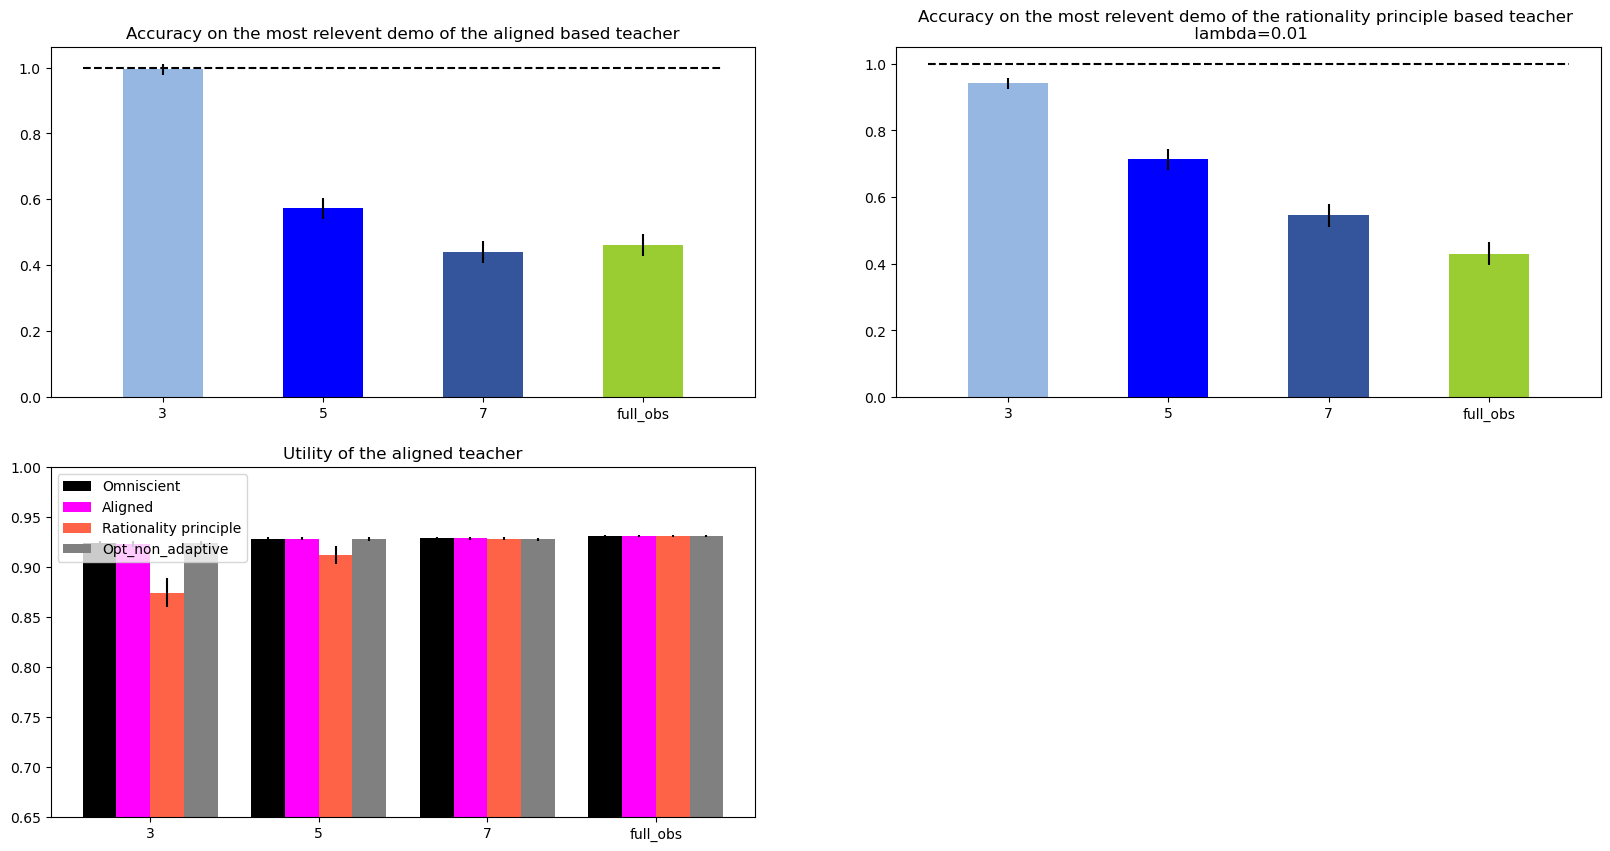

In [12]:
bayesien_all_utility_mean = []
bayesien_all_accuracy_demo_idx_mean = []
aligned_all_utility_mean = []
aligned_all_accuracy_demo_idx_mean = []
omniscient_all_utility_mean = []
opt_non_adaptive_all_utility_mean = []

bayesien_all_utility_std = []
bayesien_all_accuracy_demo_idx_std = []
aligned_all_utility_std = []
aligned_all_accuracy_demo_idx_std = []
omniscient_all_utility_std = []
opt_non_adaptive_all_utility_std = []

for rf_idx, receptive_field in enumerate(rf_values):
    bayesien_all_utility = []
    bayesien_all_accuracy_demo_idx = []

    aligned_all_utility = []
    aligned_all_accuracy_demo_idx = []

    omniscient_all_utility = []
    opt_non_adaptive_all_utility = []

    for goal_color in range(num_colors):
        bayesien_all_utility += list(
            np.array(DICT_UTIL[lambd][goal_color, receptive_field])[:, 2]
        )
        bayesien_all_accuracy_demo_idx += list(
            np.array(DICT_UTIL[lambd][goal_color, receptive_field])[:, 0]
            == np.array(DICT_UTIL["omniscient"][goal_color, receptive_field])[:, 0]
        )

        aligned_all_utility += list(
            np.array(DICT_UTIL["aligned"][goal_color, receptive_field])[:, 2]
        )
        aligned_all_accuracy_demo_idx += list(
            np.array(DICT_UTIL["aligned"][goal_color, receptive_field])[:, 0]
            == np.array(DICT_UTIL["omniscient"][goal_color, receptive_field])[:, 0]
        )

        # Baselines
        omniscient_all_utility += list(
            np.array(DICT_UTIL["omniscient"][goal_color, receptive_field])[:, 1]
        )
        opt_non_adaptive_all_utility += list(
            np.array(DICT_UTIL["opt_non_adaptive"][goal_color, receptive_field])[:, 1]
        )

    bayesien_all_utility_mean.append(np.mean(bayesien_all_utility))
    bayesien_all_accuracy_demo_idx_mean.append(np.mean(bayesien_all_accuracy_demo_idx))
    aligned_all_utility_mean.append(np.mean(aligned_all_utility))
    aligned_all_accuracy_demo_idx_mean.append(np.mean(aligned_all_accuracy_demo_idx))
    omniscient_all_utility_mean.append(np.mean(omniscient_all_utility))
    opt_non_adaptive_all_utility_mean.append(np.mean(opt_non_adaptive_all_utility))

    bayesien_all_utility_std.append(np.std(bayesien_all_utility))
    bayesien_all_accuracy_demo_idx_std.append(np.std(bayesien_all_accuracy_demo_idx))
    aligned_all_utility_std.append(np.std(aligned_all_utility))
    aligned_all_accuracy_demo_idx_std.append(np.std(aligned_all_accuracy_demo_idx))
    omniscient_all_utility_std.append(np.std(omniscient_all_utility))
    opt_non_adaptive_all_utility_std.append(np.std(opt_non_adaptive_all_utility))


fig = plt.figure(figsize=(20, 10))
colors = [
    np.array([149, 183, 226]) / 255,
    "blue",
    np.array([52, 85, 156]) / 255,
    "yellowgreen",
]

fig.add_subplot(2, 2, 1)
plt.title(f"Accuracy on the most relevent demo of the aligned based teacher")
plt.bar(
    np.array(rf_values_basic + ["full_obs"]).astype(str),
    aligned_all_accuracy_demo_idx_mean,
    width=0.5,
    yerr=1.96
    * np.array(bayesien_all_accuracy_demo_idx_std)
    / np.sqrt(len(bayesien_all_accuracy_demo_idx)),
    color=colors,
    label=f"$\lambda$={lambd}",
)
plt.plot([-0.5, 3.5], [1, 1], ls="--", c="k")

fig.add_subplot(2, 2, 2)
plt.title(
    f"Accuracy on the most relevent demo of the rationality principle based teacher \n lambda={lambd}"
)
plt.bar(
    np.array(rf_values_basic + ["full_obs"]).astype(str),
    bayesien_all_accuracy_demo_idx_mean,
    width=0.5,
    yerr=1.96
    * np.array(bayesien_all_accuracy_demo_idx_std)
    / np.sqrt(len(bayesien_all_accuracy_demo_idx)),
    color=colors,
    label=f"$\lambda$={lambd}",
)
plt.plot([-0.5, 3.5], [1, 1], ls="--", c="k")

fig.add_subplot(2, 2, 3)
plt.title(f"Utility of the aligned teacher")

bar_width = 0.2
x_pos = np.arange(len(np.array(rf_values_basic + ["full_obs"]).astype(str)))

plt.bar(
    x_pos,
    omniscient_all_utility_mean,
    width=bar_width,
    align="center",
    yerr=1.96
    * np.array(omniscient_all_utility_std)
    / np.sqrt(len(omniscient_all_utility)),
    color=["k"] * 4,
    label=f"Omniscient",
)
plt.bar(
    x_pos + bar_width,
    aligned_all_utility_mean,
    width=bar_width,
    align="center",
    yerr=1.96 * np.array(aligned_all_utility_std) / np.sqrt(len(aligned_all_utility)),
    color=["fuchsia"] * 4,
    label=f"Aligned",
)
plt.bar(
    x_pos + 2 * bar_width,
    bayesien_all_utility_mean,
    width=bar_width,
    align="center",
    yerr=1.96 * np.array(bayesien_all_utility_std) / np.sqrt(len(bayesien_all_utility)),
    color=["tomato"] * 4,
    label="Rationality principle",
)
plt.bar(
    x_pos + 3 * bar_width,
    opt_non_adaptive_all_utility_mean,
    width=bar_width,
    align="center",
    yerr=1.96
    * np.array(opt_non_adaptive_all_utility_std)
    / np.sqrt(len(opt_non_adaptive_all_utility)),
    color=["gray"] * 4,
    label=f"Opt_non_adaptive",
)

plt.xticks(
    x_pos + 1.5 * bar_width, np.array(rf_values_basic + ["full_obs"]).astype(str)
)
plt.ylim(0.65, 1)
plt.legend();

In [13]:
print(
    f"Model              Omniscient               Aligned           Rationality principle           Opt non adaptive"
)
print(
    f"Mean utility    {np.mean(omniscient_all_utility_mean):.4f} +/- {1.96 * np.sqrt(np.mean(np.array(omniscient_all_utility_std))) / np.sqrt(16*N):.4f} \
      {np.mean(aligned_all_utility_mean):.4f} +/- {1.96 * np.sqrt(np.mean(np.array(aligned_all_utility_std))) / np.sqrt(16*N):.4f} \
      {np.mean(bayesien_all_utility_mean):.4f} +/- {1.96 * np.sqrt(np.mean(np.array(bayesien_all_utility_std))) / np.sqrt(16*N):.4f} \
      {np.mean(opt_non_adaptive_all_utility_mean):.4f} +/- {1.96 * np.sqrt(np.mean(np.array(opt_non_adaptive_all_utility_std))) / np.sqrt(16*N):.4f}"
)

Model              Omniscient               Aligned           Rationality principle           Opt non adaptive
Mean utility    0.9281 +/- 0.0052       0.9278 +/- 0.0056       0.9115 +/- 0.0106       0.9278 +/- 0.0052


In [19]:
alpha = 0.3


def cost_fun(x: int, l: int) -> float:
    assert l - x >= 0
    return exp_cost(l - x, l, alpha=alpha)